<a href="https://colab.research.google.com/github/oscarserc/VISION_por_COMPUTADORA/blob/main/CV_Practica_1a_Clasificacion_de_Im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torchvision

dataset = {
    'train': torchvision.datasets.MNIST('./data', train=True,  download=True, transform=torchvision.transforms.ToTensor()),
    'test' : torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
}

len(dataset['train']), len(dataset['test'])



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(60000, 10000)

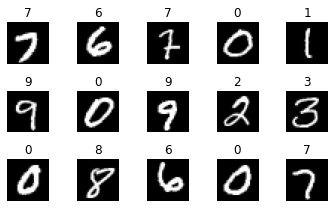

In [ ]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import random

r, c = 3, 5
fig = plt.figure(figsize=(c, r))
for _r in range(r):
  for _c in range(c):
    plt.subplot(r, c, _r*c + _c + 1)
    ix = random.randint(0, len(dataset['train']) - 1)
    img, label = dataset['train'][ix]
    plt.imshow(img.squeeze(0), cmap='gray')
    plt.axis('off')
    plt.title(label)
plt.tight_layout()
plt.show()    


In [ ]:
img.shape, img.dtype, img.max(), img.min()

(torch.Size([1, 28, 28]), torch.float32, tensor(1.), tensor(0.))

In [ ]:

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
  return torch.nn.Sequential(
      torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(pk, stride=ps)
  )

def block2(c_in, c_out):
  return torch.nn.Sequential(
      torch.nn.Linear(c_in, c_out),
      torch.nn.ReLU()
  )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc    = torch.nn.Linear(128*7*7, n_outputs) 

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x  


In [ ]:
modelo = CNN()
salidas = modelo(torch.randn(64, 1, 28, 28))
salidas.shape

torch.Size([64, 10])

In [ ]:

from tqdm import tqdm
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def fit(model, dataloader, epochs=5):
  modelo.to(device)
  optimizer = torch.optim.Adam(modelo.parameters(), lr=1e-3)
  criterion = torch.nn.CrossEntropyLoss()

  for epoch in range(1, epochs+1):
    modelo.train()      # <----------   MODO ENTRENAMIENTO
    train_loss, train_acc = [], []
    bar = tqdm(dataloader['train'])

    for batch in bar:
      X, y = batch
      X, y = X.to(device), y.to(device)

      y_hat = modelo(X)
      loss = criterion(y_hat, y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      acc = ( y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
      train_loss.append(loss.item())
      train_acc.append(acc)
      bar.set_description(f'loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}')

    bar = tqdm(dataloader['test'])
    val_loss, val_acc = [], []
    model.eval()        # <----------    MODO EVALUACIÓN
    with torch.no_grad():
      for batch in bar:
        X, y = batch
        X, y = X.to(device), y.to(device)

        y_hat = modelo(X)
        loss = criterion(y_hat, y)

        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        val_loss.append(loss.item())
        val_acc.append(acc)
        bar.set_description(f'val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}')
    print(f'Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}')    


In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=64, shuffle=True,  pin_memory=True),
    'test' : torch.utils.data.DataLoader(dataset['test'] , batch_size=64, shuffle=False, pin_memory=True)
}

imgs, labels = next(iter(dataloader['train']))
imgs.shape


torch.Size([64, 1, 28, 28])

In [ ]:
modelo = CNN()
fit(modelo, dataloader)

val_loss 0.05024 val_acc 0.98467: 100%|██████████| 157/157 [00:03<00:00, 49.60it/s]


Epoch 1/5 loss 0.14593 val_loss 0.05024 acc 0.95574 val_acc 0.98467


val_loss 0.03762 val_acc 0.98816: 100%|██████████| 157/157 [00:03<00:00, 46.84it/s]


Epoch 2/5 loss 0.04549 val_loss 0.03762 acc 0.98601 val_acc 0.98816


val_loss 0.03483 val_acc 0.98945: 100%|██████████| 157/157 [00:03<00:00, 45.75it/s]


Epoch 3/5 loss 0.03230 val_loss 0.03483 acc 0.99001 val_acc 0.98945


val_loss 0.03383 val_acc 0.98875: 100%|██████████| 157/157 [00:03<00:00, 44.51it/s]


Epoch 4/5 loss 0.02468 val_loss 0.03383 acc 0.99242 val_acc 0.98875


val_loss 0.03031 val_acc 0.99045: 100%|██████████| 157/157 [00:03<00:00, 40.22it/s]

Epoch 5/5 loss 0.01907 val_loss 0.03031 acc 0.99392 val_acc 0.99045


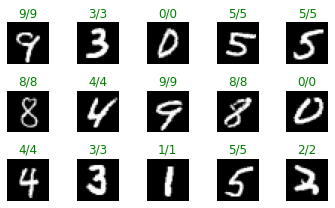

In [ ]:
r, c = 3, 5
fig = plt.figure(figsize=(c,r))
for _r in range(r):
  for _c in range(c):
    plt.subplot(r, c, _r*c + _c + 1)
    ix = random.randint(0, len(dataset['test']) - 1)
    img, label = dataset['test'][ix]
    predicciones = modelo(img.unsqueeze(0).to(device))
    pred         = torch.argmax(predicciones, axis=1)[0].item()
    plt.imshow(img.squeeze(0), cmap='gray')
    plt.axis('off')
    plt.title(f'{label}/{pred}', color='red' if label != pred else 'green')
plt.tight_layout()
plt.show()    
